## 卷积神经网络实现文本情感分类

In [1]:
%load_ext watermark
%watermark -p tensorflow,numpy -v -m

CPython 3.4.3
IPython 5.3.0

tensorflow 1.0.1
numpy 1.12.0

compiler   : GCC 4.8.4
system     : Linux
release    : 4.9.8-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline
from collections import Counter
import time
import jieba
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 语料处理

* 去除空格/数字/部分标点/少量stopwords
* 变长度的句子不便作为神经网络的输入, 因此需先处理为固定长度. 超过固定长度的, 直接截断; 小于固定长度的, 用 padding 补齐.
* 将词转换为词序号
* 与 nn_sentiment.ipynb 的区别是, 语料由四个文件变成了两个文件.

In [3]:
IGNORE = ' \n'  # 忽略的字符
DOC_LENGTH = 20  # 预设的固定句子长度
PADDING = '<PD>'  # 句子长度不足时的占位符

def read_docs_and_labels(file):
    """从文件读取样本, 去除忽略字符, 得到句子和标签列表"""    
    with open(file, encoding='utf-8') as f:
        lines = f.readlines()
    
    docs, labels = [], []
    for line in lines:
        text, label = line.split('\t')

        words_in_doc = []
        for word in jieba.cut(text):
            if (word not in IGNORE) and (not word.isdigit()):
                words_in_doc.append(word)

        docs.append(words_in_doc)
        labels.append(int(label.strip()))

    return docs, labels

def fix_doc_length(docs):
    """将所有样本的词列表调整为固定长度"""
    for i in range(len(docs)):
        if len(docs[i]) < DOC_LENGTH:
            docs[i].extend([PADDING] * (DOC_LENGTH - len(docs[i])))
        else:
            docs[i] = docs[i][:DOC_LENGTH]
    return docs

def get_word_counter(docs):
    flat_words = [w for doc in docs for w in doc]
    return Counter(flat_words)

def build_vocab(word_cnt, limit=3):
    """建立词表, 仅计入出现次数超过设定值(默认为3)的词"""
    vocab = ['UNK']
    for word, count in word_cnt.most_common():
        if count > limit:
            vocab.append(word)
        else:
            break
    return vocab

In [4]:
train_file = 'train_shuffle.txt'
test_file = 'test_shuffle.txt'

train_docs, train_labels = read_docs_and_labels(train_file)
test_docs, test_labels = read_docs_and_labels(test_file)

train_docs = fix_doc_length(train_docs)
test_docs = fix_doc_length(test_docs)

# 由训练样本集建立词表
word_cnt = get_word_counter(train_docs)
vocab = build_vocab(word_cnt)
vocab_size = len(vocab)
idx_dict = dict(zip(vocab, range(vocab_size)))  # 由词映射到词序号的字典
print('** vocab_size = {} **'.format(vocab_size))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.742 seconds.
Prefix dict has been built succesfully.


** vocab_size = 7024 **


In [5]:
print(word_cnt.most_common(50))

[('<PD>', 64051), ('，', 36572), ('的', 22834), ('。', 10025), ('了', 8714), (',', 6448), ('是', 6313), ('很', 5024), ('我', 4928), ('酒店', 4025), ('也', 3160), ('在', 2961), ('不错', 2915), ('不', 2885), ('房间', 2863), ('.', 2612), ('！', 2595), ('有', 2562), ('好', 2522), ('都', 2461), ('还', 2449), ('没有', 2326), ('就', 2264), ('、', 1976), ('这', 1922), ('和', 1773), ('比较', 1707), ('：', 1548), ('看', 1532), ('服务', 1515), ('买', 1499), ('感觉', 1477), ('可以', 1468), ('本书', 1309), ('住', 1287), ('非常', 1284), ('就是', 1240), ('到', 1233), ('还是', 1225), ('用', 1198), ('入住', 1188), ('说', 1178), ('月', 1171), ('书', 1066), ('一个', 1046), ('但', 1037), ('系统', 1005), ('这个', 1003), ('日', 959), ('有点', 941)]


In [6]:
def docs2idxes(docs):
    """把词列表的列表转换为序号列表的列表"""
    idxes = []
    for doc in docs:
        idxes_of_one_doc = []
        for word in doc:
            idx = idx_dict[word] if (word in vocab) else 0
            idxes_of_one_doc.append(idx)
        idxes.append(idxes_of_one_doc)
    return idxes

train_idxes = docs2idxes(train_docs)
inputs_train = np.asarray(train_idxes)
labels_train = np.asarray(train_labels)

test_idxes = docs2idxes(test_docs)
inputs_test = np.asarray(test_idxes)
labels_test = np.asarray(test_labels)

In [7]:
inputs_train.shape, labels_train.shape, inputs_test.shape, labels_test.shape

((24586, 20), (24586,), (10538, 20), (10538,))

### 定义神经网络

输入词序号 -> 词向量 -> 卷积层(tanh) -> pool 层 -> 全连接层(sigmoid) -> 输出分类

In [8]:
word_embed_size = 30
filter_num = 30
window_size = 3

In [9]:
# 随机生成词向量
tf.reset_default_graph()
W = tf.Variable(tf.random_uniform([vocab_size, word_embed_size], -1.0, 1.0), name="W")

inputs = tf.placeholder(tf.int32, shape=[None, DOC_LENGTH], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

embeds = tf.nn.embedding_lookup(W, inputs)

# 为了适应 conv2d 的参数，拓展了一个维度 (in_channel)，长度是 1
embeds_expand = tf.expand_dims(embeds, -1)
embeds, embeds_expand

(<tf.Tensor 'embedding_lookup:0' shape=(?, 20, 30) dtype=float32>,
 <tf.Tensor 'ExpandDims:0' shape=(?, 20, 30, 1) dtype=float32>)

In [10]:
# 构建 conv 层 + pool 层
with tf.name_scope("conv-maxpool"):
    filter_shape = [window_size, word_embed_size, 1, filter_num]
    # W 和 b 是卷积的参数
    W = tf.Variable(tf.random_uniform(filter_shape, -1.0, 1.0), name="W")
    # bias 和 filter_num 个数是一样的
    b = tf.Variable(tf.constant(0.0, shape=[filter_num]), name="b")
    # 步长为1，这里不做 Padding，因此句子太短的话可能要丢掉。可自行尝试加 padding
    conv = tf.nn.conv2d(
        embeds_expand, W, strides=[1, 1, 1, 1],
        padding="VALID", name="conv")

    # 卷积出来的结果加上 bias
    conv_hidden = tf.nn.tanh(tf.add(conv, b), name="tanh")

    # 因为没有 padding，出来的结果个数是 sequence_length - window_size + 1
    # 如果加了 padding 这里要对应更改
    pool = tf.nn.max_pool(
        conv_hidden,
        ksize=[1, DOC_LENGTH - window_size + 1, 1, 1],
        strides=[1, 1, 1, 1],
        padding='VALID',
        name="pool")

conv, conv_hidden, pool

(<tf.Tensor 'conv-maxpool/conv:0' shape=(?, 18, 1, 30) dtype=float32>,
 <tf.Tensor 'conv-maxpool/tanh:0' shape=(?, 18, 1, 30) dtype=float32>,
 <tf.Tensor 'conv-maxpool/pool:0' shape=(?, 1, 1, 30) dtype=float32>)


童老师提示:
> 目前 tensorflow 还不支持动态 max_pool size，所以 ksize 只能用常数固定，
> 因为不同句子 sequence_length 不一样，因此目前这里目前还没法做到处理边长句子。  
> 一个解决方案是用人工 Padding 的方式，根据语料中最长的句子的长度来扩展所有句子，归一化到统一的长度。即所有句子都通过 Padding 一个特殊符号的方式，扩展为固定长度。
> **注意这个是 Tensorflow 目前的限制**，用其他一些支持动态 max_pool 的库不需要 padding。事实上这也会造成计算量的浪费。

In [11]:
squeezed_pool = tf.squeeze(pool, [1, 2])
raw_output = tf.layers.dense(squeezed_pool, 2)
output = tf.nn.softmax(raw_output)
raw_output.shape, labels_train.shape

(TensorShape([Dimension(None), Dimension(2)]), (24586,))

In [12]:
cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=raw_output, labels=labels))

### 训练

* 随机梯度下降, 每个训练步读一个样本


In [13]:
def evaluate_model(sess, inputs_, labels_, print_matrix=False):
    """评估模型指标, 并打印输出"""
    pred_prob = sess.run(output, feed_dict={inputs:inputs_, labels:labels_})
    preds = np.asarray((pred_prob[:, 1] > 0.5), dtype=int)
    mat = sess.run(tf.confusion_matrix(labels_, preds))
    tn, fp, fn, tp = mat.reshape(4)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if print_matrix:
        print(' confusion matrix:\n', mat)
    print(' precision {:.3f}, recall {:.3f}'.format(precision, recall))
    # return preds, mat, precision, recall

In [19]:
batch_size = 100
epochs = 2000
print_cost_every = 10
learning_rate = 1

feed_train = {inputs: inputs_train, labels: labels_train}
feed_test = {inputs: inputs_test, labels: labels_test}

sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

costs_train = []
costs_test = []
start_time = time.time()

num_inputs = len(labels_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_train = sess.run(cost, feed_dict=feed_train)
            cost_test = sess.run(cost, feed_dict=feed_test)
            costs_train.append(cost_train)
            costs_test.append(cost_test)
            print('epoch {:03d} cost: train {:.5f} / test {:.5f}'.format(
                i, cost_train, cost_test))
            evaluate_model(sess, inputs_test, labels_test)
 
        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('Interrupted')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

round 000 cost: train 1.79844 / test 1.79639
 precision nan, recall 0.000


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in int_scalars


round 010 cost: train 0.15011 / test 0.56878
 precision 0.800, recall 0.866
round 020 cost: train 0.02440 / test 0.73127
 precision 0.892, recall 0.868
round 030 cost: train 0.01742 / test 0.82138
 precision 0.893, recall 0.869
round 040 cost: train 0.01290 / test 0.86818
 precision 0.895, recall 0.877
round 050 cost: train 0.01004 / test 0.90180
 precision 0.896, recall 0.879
round 060 cost: train 0.00866 / test 0.93072
 precision 0.896, recall 0.882
round 070 cost: train 0.00754 / test 0.94952
 precision 0.895, recall 0.883
round 080 cost: train 0.00626 / test 0.96319
 precision 0.894, recall 0.886
round 090 cost: train 0.00573 / test 0.98319
 precision 0.895, recall 0.883
Interrupted

time: 105.17 s


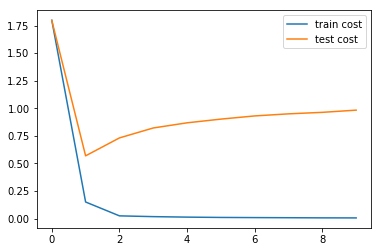

In [20]:
plt.plot(costs_train, label='train cost')
plt.plot(costs_test, label='test cost')
plt.legend();

### 评估


In [21]:
print('\n** train set **')
evaluate_model(sess, inputs_train, labels_train, print_matrix=True)
print('\n** test set **')
evaluate_model(sess, inputs_test, labels_test, print_matrix=True);


** train set **
 confusion matrix:
 [[12984    19]
 [   48 11535]]
 precision 0.998, recall 0.996

** test set **
 confusion matrix:
 [[5069  504]
 [ 587 4378]]
 precision 0.897, recall 0.882


### ChangeLog

* v-pre
    * 条件: 句长 20, 词向量维数 30, filter_num = 15, window size = 3
    * 结果:
        * train: precision 0.982, recall 0.648
        * test: precision 0.920, recall 0.566
    * 分析: 训练集都没拟合好, 模型偏 high-bias. 尝试增加参数.
* v0
    * v-pre -> filter_num 15->30
    * 结果
        * train: precision 0.825, recall 0.823
        * test: precision 0.752, recall 0.780
    * 分析: 增加 filter_num 改善了 recall. 但模型仍然偏 high-bias.
* v0a
    * v0 -> 词向量维数 30->60
    * 结果
        * train: precision 0.817, recall 0.791
        * test: precision 0.761, recall 0.746
    * 分析: 没效果. 突然想到: 忽略标点和少数极高频词是否影响了小特征的捕捉?
* v1
    * v0 -> **不忽略标点和少数极高频词**, 学习率 0.1->0.03
    * 结果
        * train: precision 0.987, recall 0.984
        * test: precision 0.906, recall 0.905
* v2
    * 改用小批量梯度下降
    * 结果
        * train: precision 0.996, recall 0.997
        * test: precision 0.881, recall 0.881
* v2a
    * v2 的学习率选得太小了! 
    * 学习率, 从 0.03 增大到 1, 训练时间从 20+ 分钟减少到 不到2分钟...
* 其他改进方向
    * 补 padding, 应能提高短句的准确率

### 小结

常规神经网络的特点就在于, ... 没有特点. 它没有进行特别的优化, 每层神经元与上一层都是完全连接, 导致模型的参数很多, 容易出现过拟合. CNNs 则采用了一种非常巧妙的方法. 在图像处理问题上, CNNs 非常符合直觉, 比如: 
* 位置不变性 (location invariance): 一个特征无论出现在何处, 都会以同样的方式被捕捉到.
* compositionality: 小的特征一级一级向上组成大的特征.

在 NLP 领域, 这两种特点并不那么符合直觉. 但实践证明, 它的表现相当好. CNNs 至少有两大优点:
* 快
* 在模型表现(representation)上很高效 (相比 n-grams)

CNNs 模型调校的难点在于, 它有较多超参数需要确定. 比如: 
* input representations
* filter 的数量和尺寸
* 是否做 zero padding
* 步长(stride size)
* pooling 方式 (max 一般优于 average)
* 激活函数
* 正则化参数
* ...

[这篇论文](https://arxiv.org/abs/1510.03820) 对不同超参数如何取值进行了研究, 给出了一些实用建议. 需要搭建一个 CNNs 时, 可以从此文推荐的 baseline configuration 开始.

### 参考

* [udacity Deep Learning - CNNs](https://classroom.udacity.com/courses/ud730/lessons/6377263405/concepts/66010388990923#)
    * 直观易懂
* [Understanding Convolutional Neural Networks for NLP – WildML](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp)
    * 清晰明白, 比较简洁. 文章最后介绍了几篇经典论文.
* [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)
    * 内容多而全. 我只看了 Overview 和 Convolutional Layer 这两部分.